# Development

All code here is experimental. Please see README for current usage instructions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import seaborn as sns

from forecastiso.data_loader import ISODataLoader
from forecastiso.features import (
    FeatureManager,
    LagFeatureGenerator,
    RollingFeatureGenerator,
    CalendarFeatureGenerator,
    InteractionFeatureGenerator,
    WindowFeatureGenerator
)
from forecastiso.forecasters import XGBForecaster

plt.style.use("./project.mplstyle")

# plt.style.use("seaborn-v0_8-paper")
# plt.style.use("bmh")

In [3]:
df = pd.read_pickle("../data/caiso_hourly/preprocessed_hourly_load.pkl")
df.head()

,datetime,area,load
0,2021-01-01 00:00:00,caiso,21447.230233
1,2021-01-01 01:00:00,caiso,20582.803317
2,2021-01-01 02:00:00,caiso,19930.106541
3,2021-01-01 03:00:00,caiso,19621.308843
4,2021-01-01 04:00:00,caiso,19610.888536


In [4]:
# limit to one area
df = df[df["area"] == "caiso"]
df = df.drop(columns=["area"])

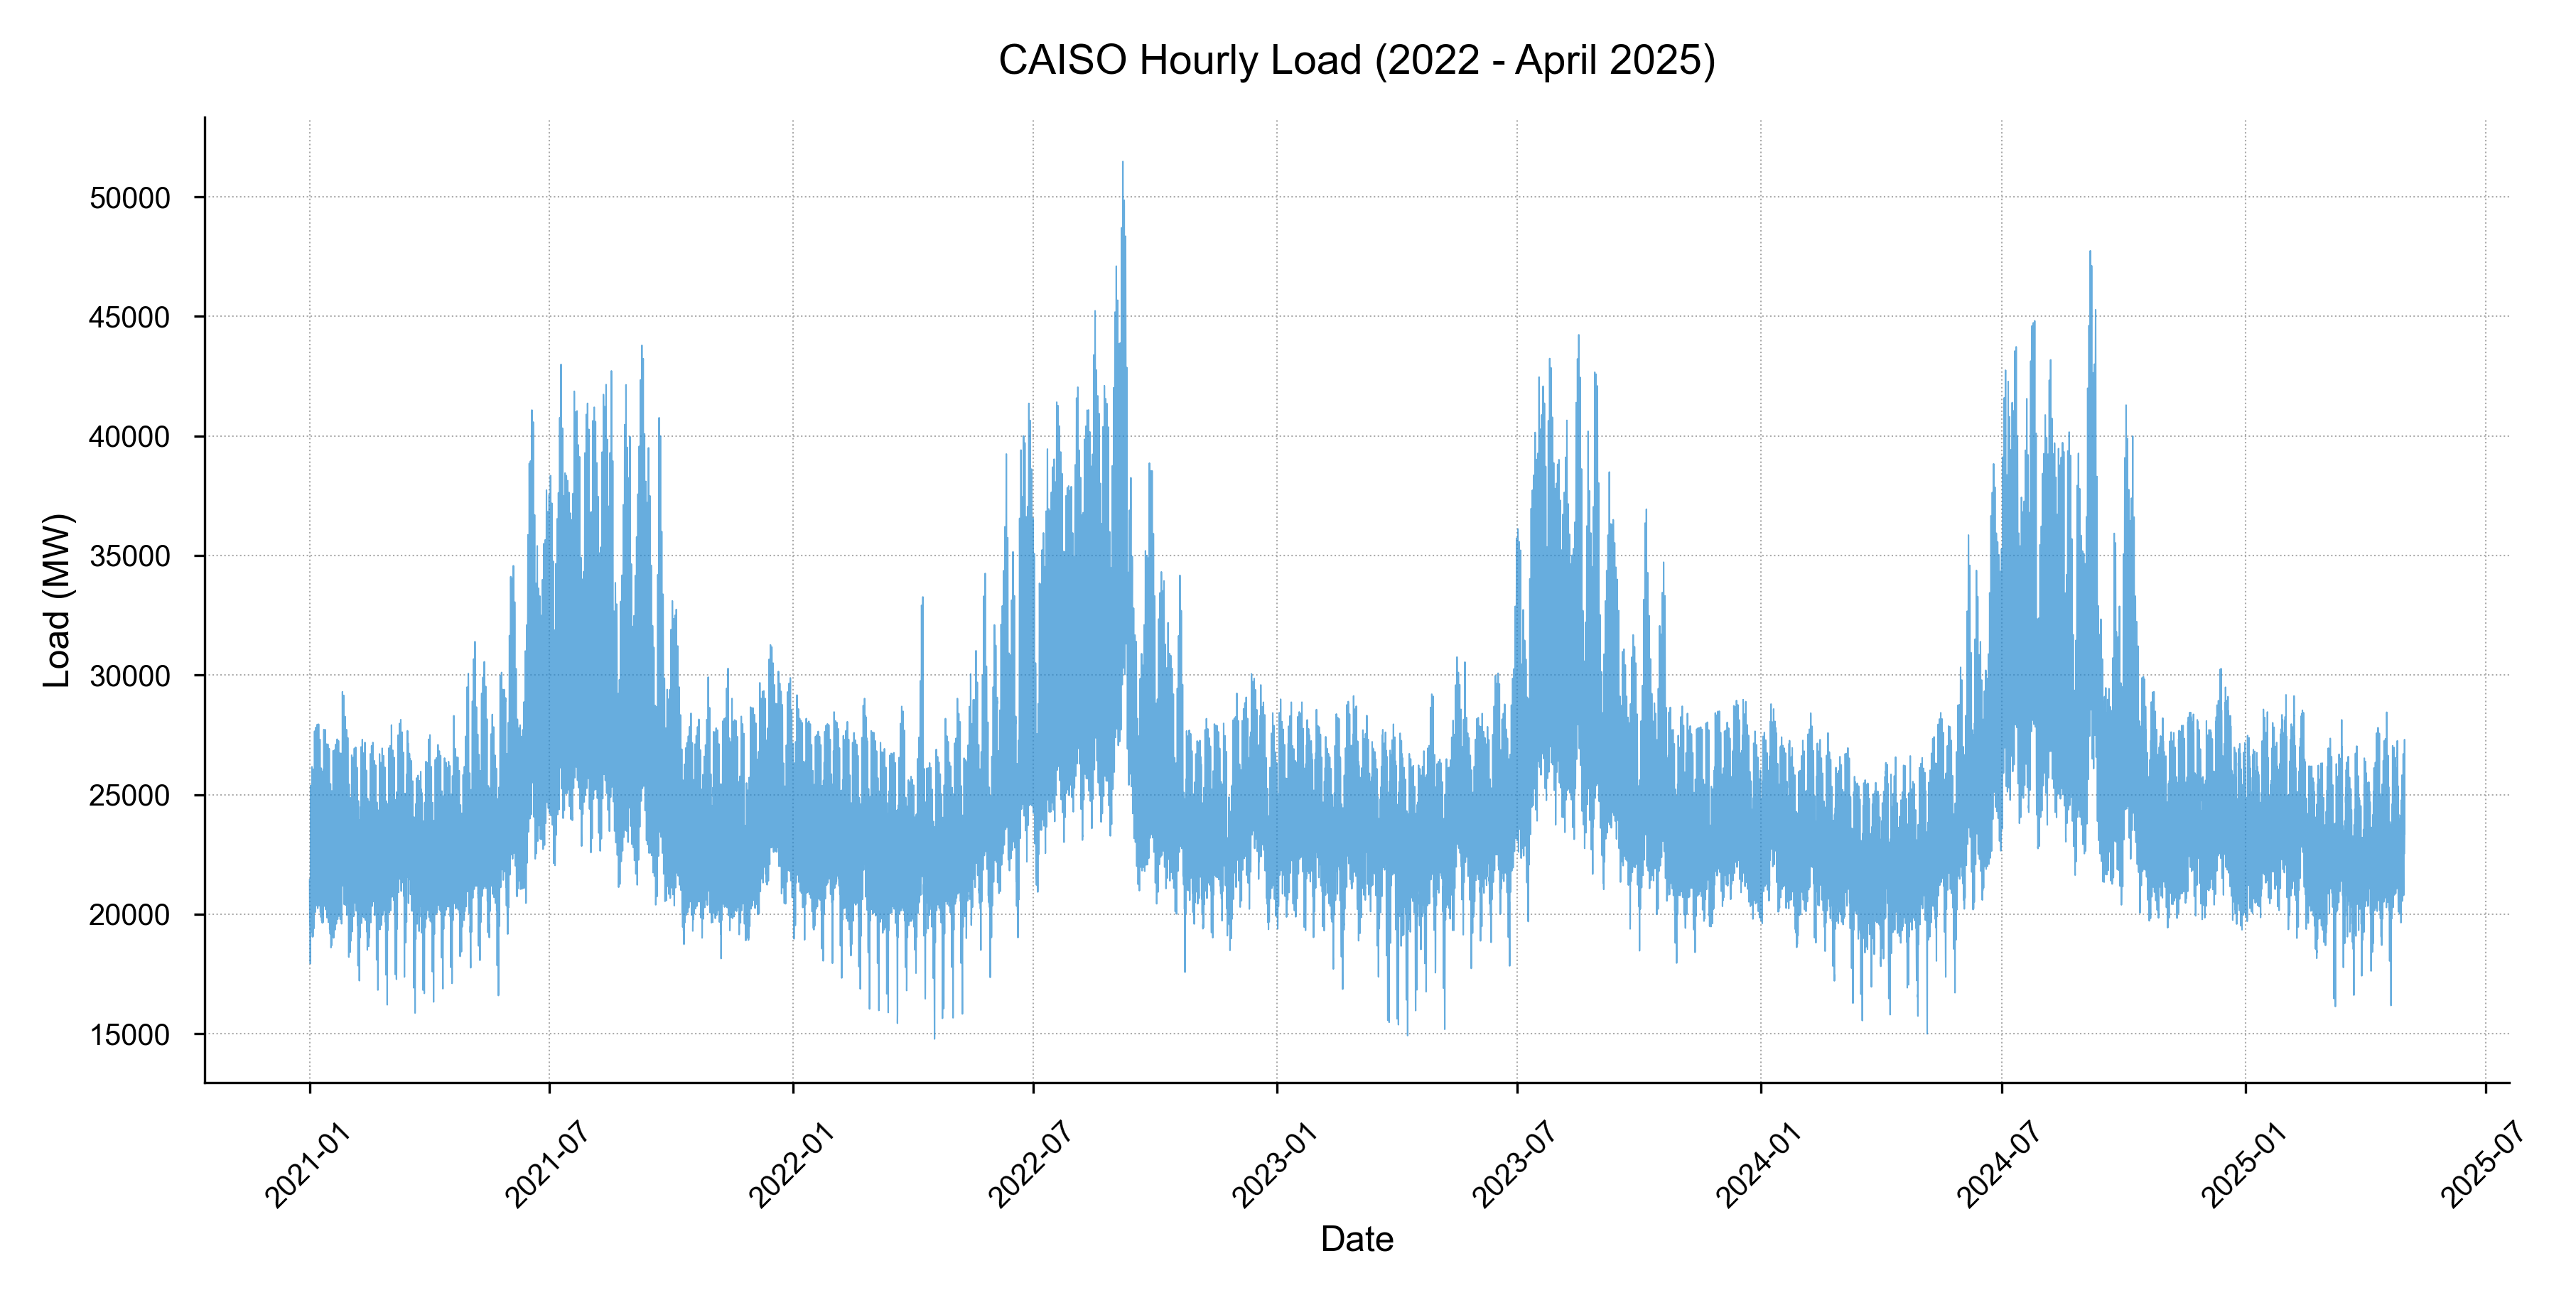

In [5]:
# line plot
plt.figure(figsize=(12, 6))
plt.plot(df["datetime"], df["load"], label="Load", linewidth=0.5, alpha=0.7)
plt.title("CAISO Hourly Load (2022 - April 2025)")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.xticks(rotation=45)
plt.show()

In [6]:
# filter for a specific date range
start_date = "2022-01-01"
predict_date = "2025-02-12"
df_filtered = df[(df["datetime"] >= start_date) & (df["datetime"] < predict_date)]

ground_truth = df[df["datetime"].dt.strftime("%Y-%m-%d") == predict_date]["load"].reset_index(drop=True)

In [7]:
df_filtered.head()

,datetime,load
8760,2022-01-01 00:00:00,22303.67
8761,2022-01-01 01:00:00,21491.08
8762,2022-01-01 02:00:00,21041.72
8763,2022-01-01 03:00:00,20875.96
8764,2022-01-01 04:00:00,20901.42


In [8]:
df_filtered.tail()

,datetime,load
36067,2025-02-11 19:00:00,27952.399986
36068,2025-02-11 20:00:00,27377.637563
36069,2025-02-11 21:00:00,26548.832918
36070,2025-02-11 22:00:00,25033.677535
36071,2025-02-11 23:00:00,23393.151125


In [9]:
# generate features

fm = FeatureManager()
fm.add_generator(LagFeatureGenerator(column="load", lags=[24, 48, 168]))
fm.add_generator(RollingFeatureGenerator(column="load", windows=[24, 168, 720]))
fm.add_generator(CalendarFeatureGenerator())
fm.add_generator(WindowFeatureGenerator(column="load", window_sizes=[24]))

features_df = fm.generate_features(df_filtered)

print(features_df.shape)
print(features_df.columns)
print(features_df.index.max())
# print(features_df.dtypes)

(27120, 63)
Index(['load', 'load_lag_24', 'load_lag_48', 'load_lag_168',
       'load_rolling_mean_24', 'load_rolling_std_24', 'load_rolling_min_24',
       'load_rolling_max_24', 'load_rolling_mean_168', 'load_rolling_std_168',
       'load_rolling_min_168', 'load_rolling_max_168', 'load_rolling_mean_720',
       'load_rolling_std_720', 'load_rolling_min_720', 'load_rolling_max_720',
       'hour', 'dow', 'month', 'day', 'quarter', 'year', 'doy', 'is_weekend',
       'day_before_weekend', 'is_holiday', 'day_before_holiday',
       'day_after_holiday', 'target_dow', 'target_month', 'target_day',
       'target_quarter', 'target_year', 'target_doy', 'target_is_weekend',
       'target_day_before_weekend', 'target_is_holiday',
       'target_day_before_holiday', 'target_day_after_holiday',
       'load_window_24_0', 'load_window_24_1', 'load_window_24_2',
       'load_window_24_3', 'load_window_24_4', 'load_window_24_5',
       'load_window_24_6', 'load_window_24_7', 'load_window_24_8',


In [10]:
# windowed_feature_cols = [f"load_window_{24}_{i}" for i in range(0, 24)]
# # windowed_feature_cols = []
# feature_cols = ["load_lag_24", "load_lag_48", "load_lag_168",
#                 "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
#                 "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
#                 "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
#                 "hour", "target_month", "target_dow", "target_doy", "target_is_holiday", "target_day_before_holiday", "target_is_weekend", 
#                 "target_day", "target_quarter", "target_year"] + windowed_feature_cols

# # target_doy, target_year

# windowed_xgb = XGBForecaster(
#     target_col="load",
#     feature_cols=feature_cols,
#     max_depth=6,
#     # n_estimators=300,
# )

# windowed_xgb.fit(features_df)
# # windowed_xgb.fit(features_df_copy)

# # prediction = windowed_xgb.predict(horizon=24)

In [ ]:
first_test_date = "2024-01-01"
last_test_date = "2024-01-31"
test_days = (pd.to_datetime(last_test_date) - pd.to_datetime(first_test_date)).days
train_days = 730


from forecastiso.evaluator import Evaluator


evaluator = Evaluator(
    retrain_frequency=7,
    train_days=train_days,
    horizon=24,
    verbose=True
)

results = evaluator.evaluate(
    model_class=XGBForecaster,
    model_kwargs={"max_depth": 6},
    features_df=full_features_df,
    target_col="load",
    feature_cols=feature_cols,
    first_test_date=first_test_date,
    last_test_date=last_test_date
)

Training models: 100%|██████████| 5/5 [00:53<00:00, 10.62s/model, date=2024-01-29]

Evaluation complete. Trained 5 models, processed 30 days.


In [16]:
evaluator.print_summary()


Evaluation Summary (30 days):
----------------------------------------
MAPE:
  Mean: 0.0323
  Std:  0.0173
  Range: [0.0117, 0.1040]

MAE:
  Mean: 758.3141
  Std:  376.4838
  Range: [278.5136, 2204.4644]

RMSE:
  Mean: 944.3181
  Std:  434.4032
  Range: [369.7105, 2558.2396]

ME:
  Mean: -32.6752
  Std:  754.3775
  Range: [-1531.8408, 2179.3501]



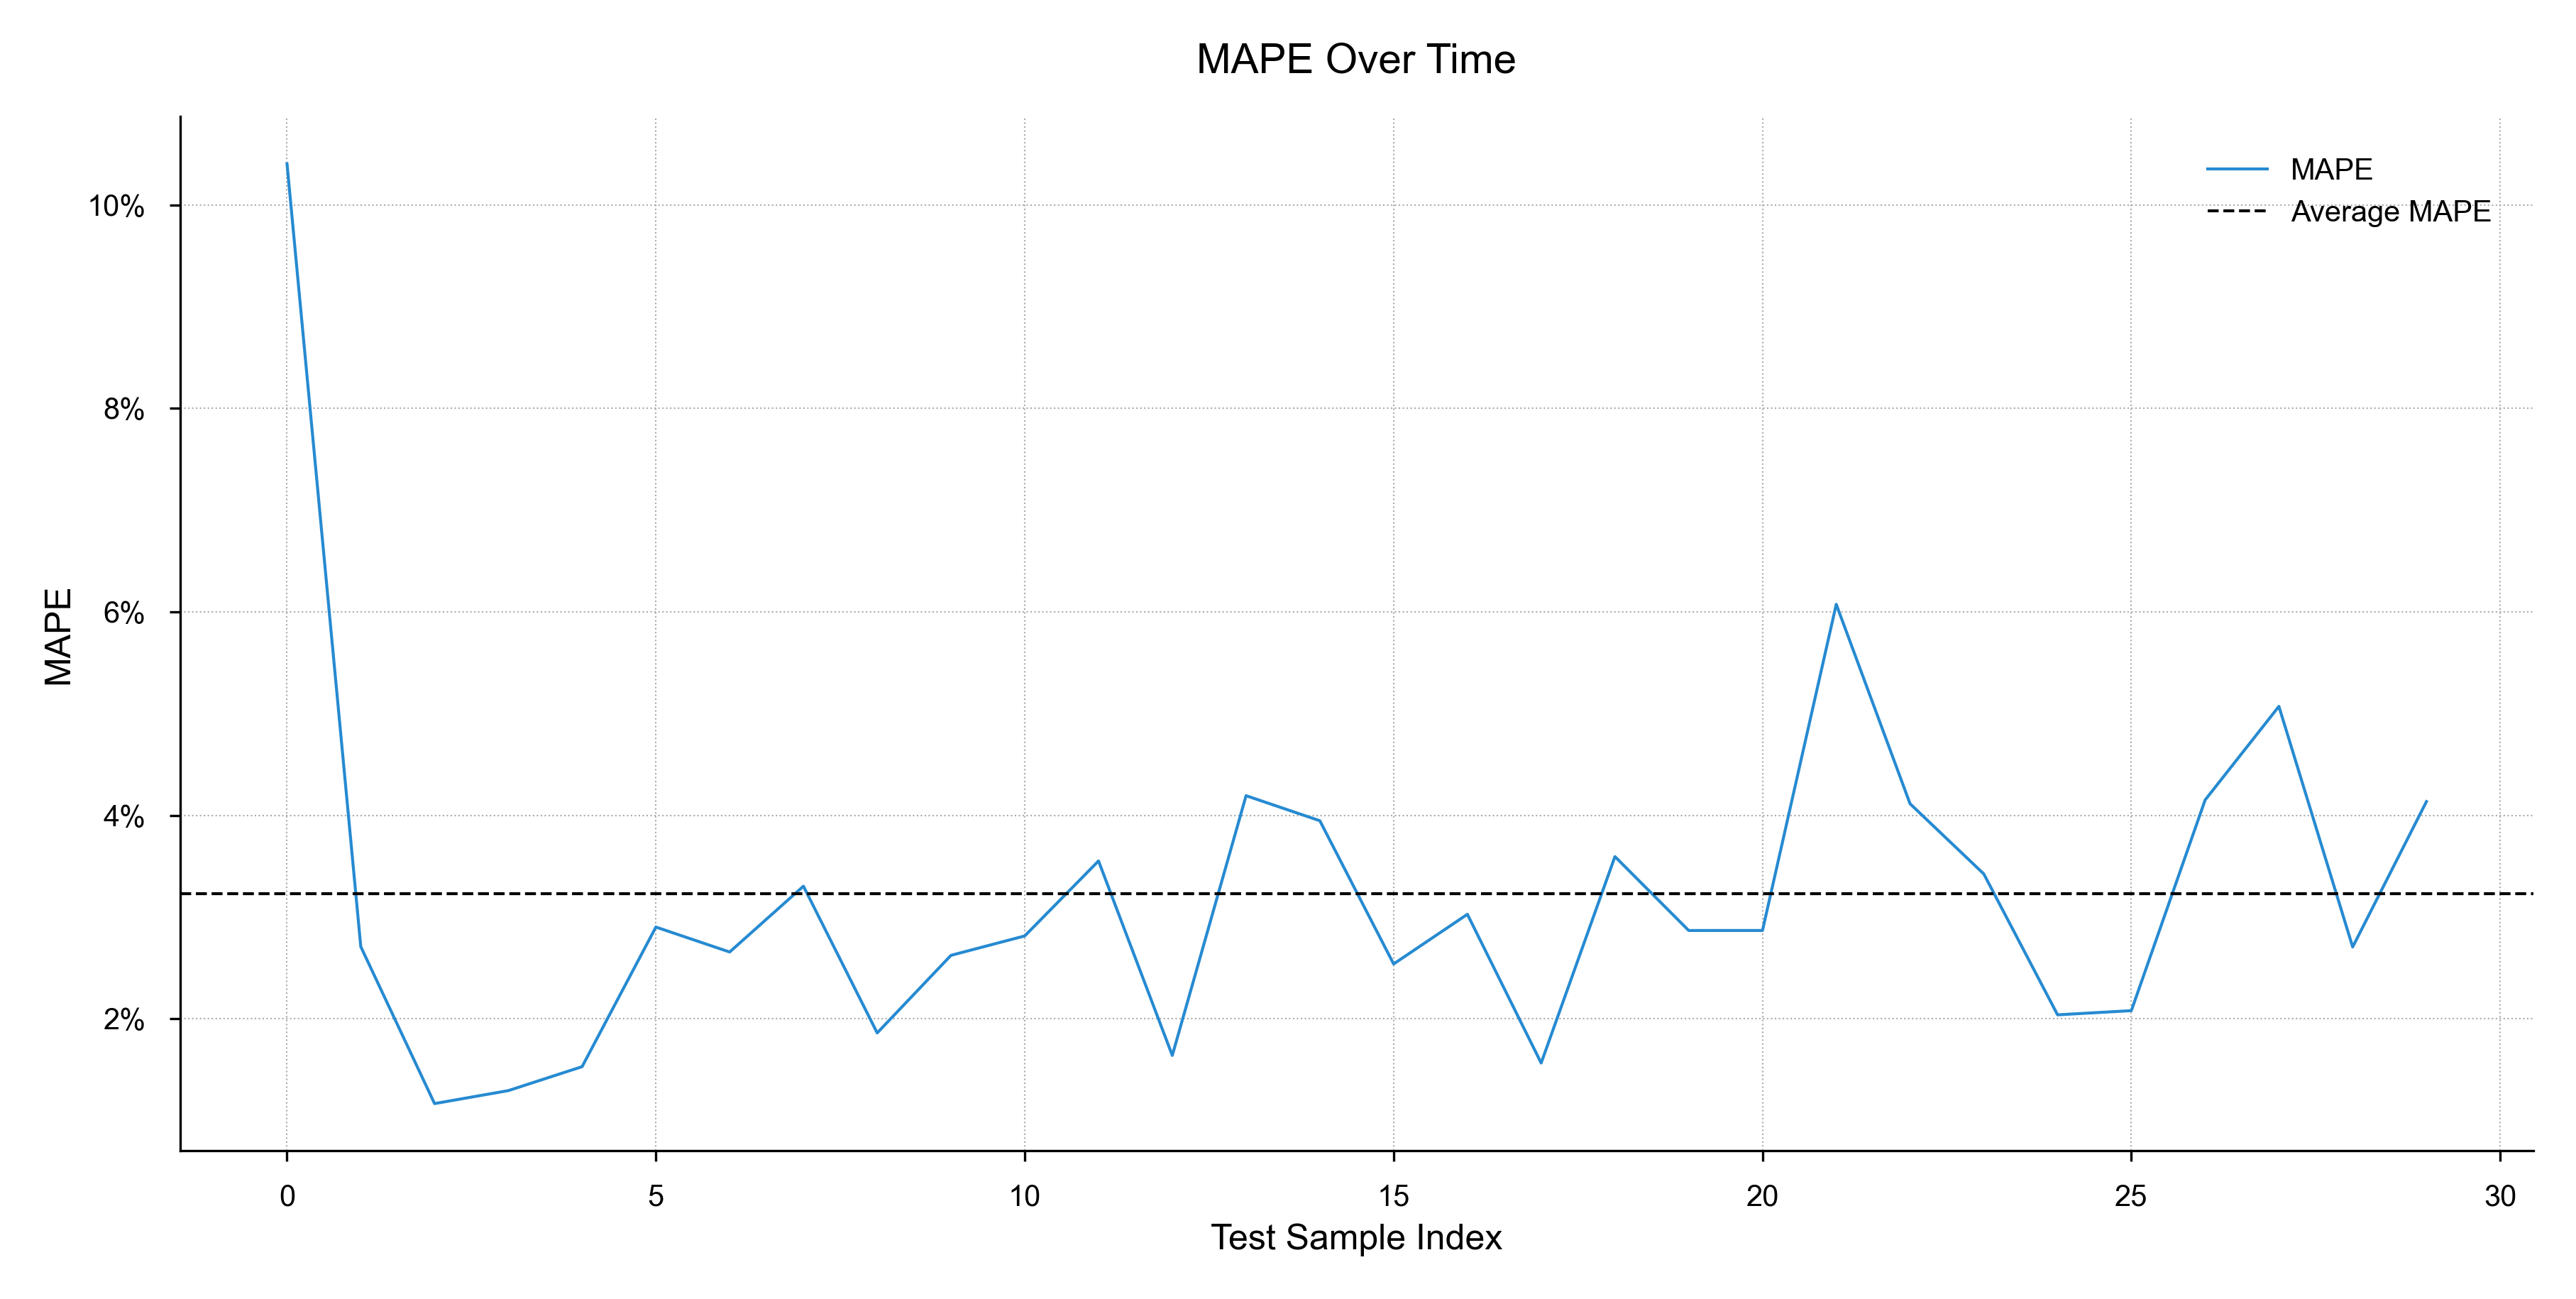

In [17]:
daily_mape = results["daily_metrics"]["mape"]

plt.figure(figsize=(12, 6))
plt.plot(daily_mape, label="MAPE", linewidth=1)
plt.axhline(np.mean(daily_mape), color="black", linestyle="--", linewidth=1, label="Average MAPE")
plt.title(f"MAPE Over Time")
plt.xlabel("Test Sample Index")
plt.ylabel("MAPE")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.legend()
plt.show()

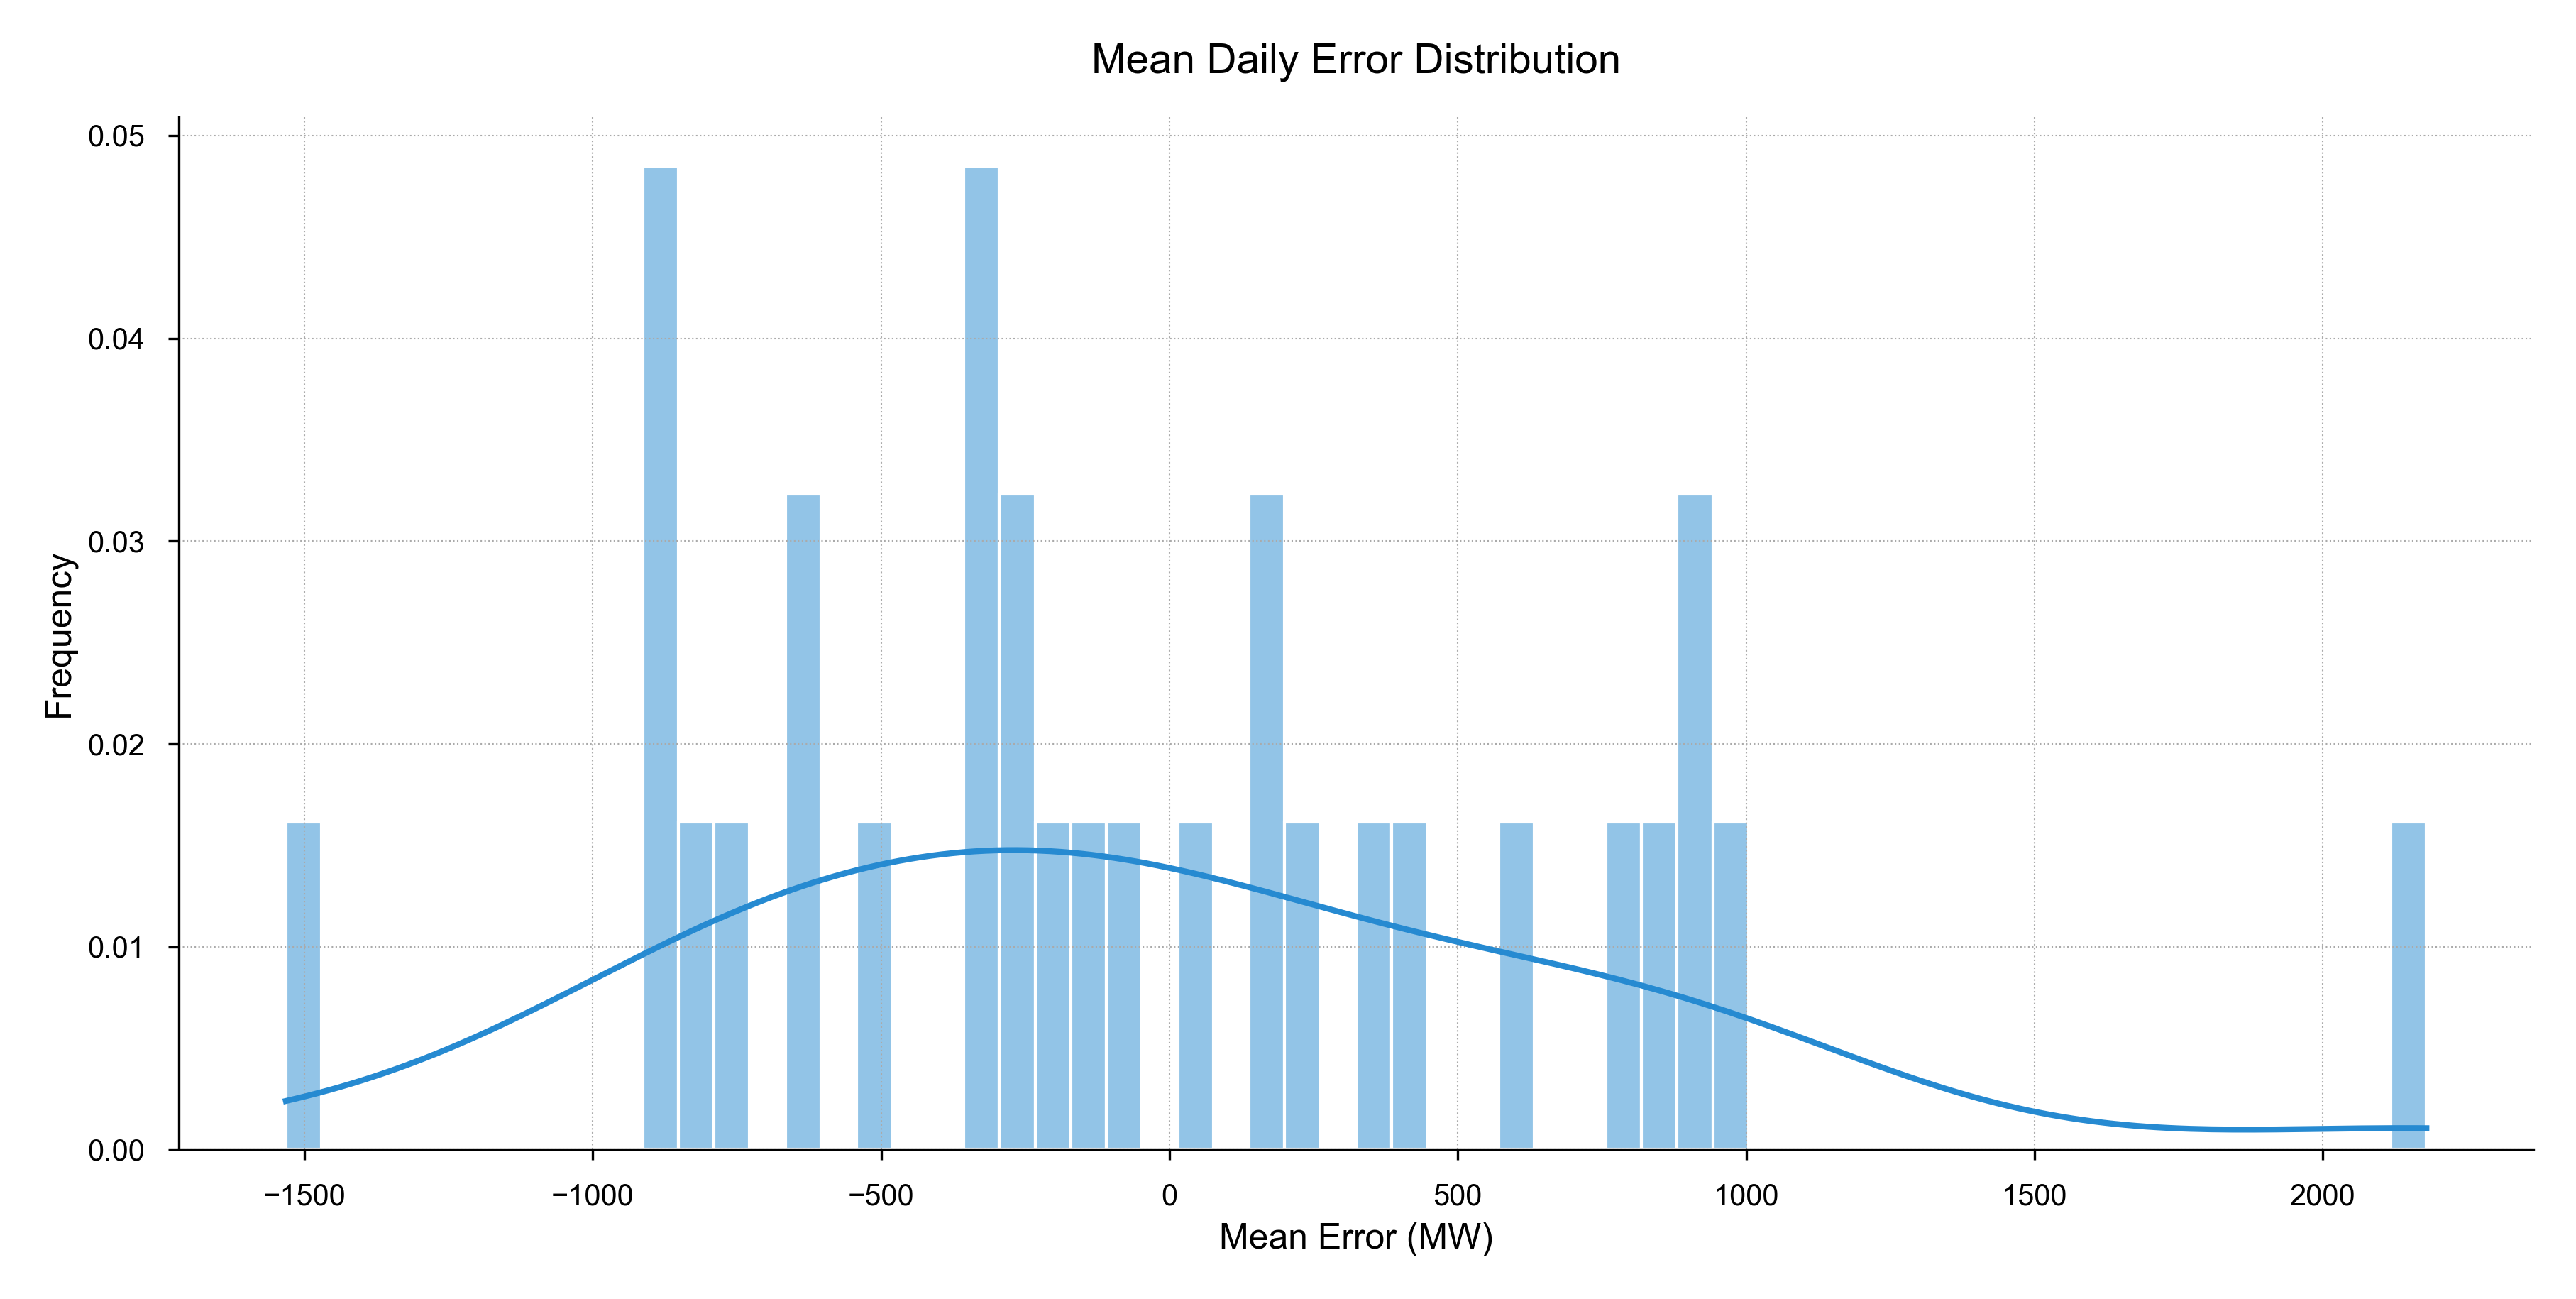

In [18]:
daily_me = results["daily_metrics"]["me"]

# plot histogram with seaborn
plt.figure(figsize=(12, 6))
sns.histplot(daily_me, bins=60, kde=True, stat="frequency", line_kws={"linewidth": 2}, edgecolor="white", alpha=0.5)
# plt.axvline(np.mean(me_list), color="black", linestyle="--", linewidth=1)
plt.title("Mean Daily Error Distribution")
plt.xlabel("Mean Error (MW)")
plt.ylabel("Frequency")
plt.show()

In [19]:


avg_predictions = np.mean(results["predictions"], axis=0)
avg_true_values = np.mean(results["true_values"], axis=0)

avg_predictions.shape, avg_true_values.shape

((24,), (24,))

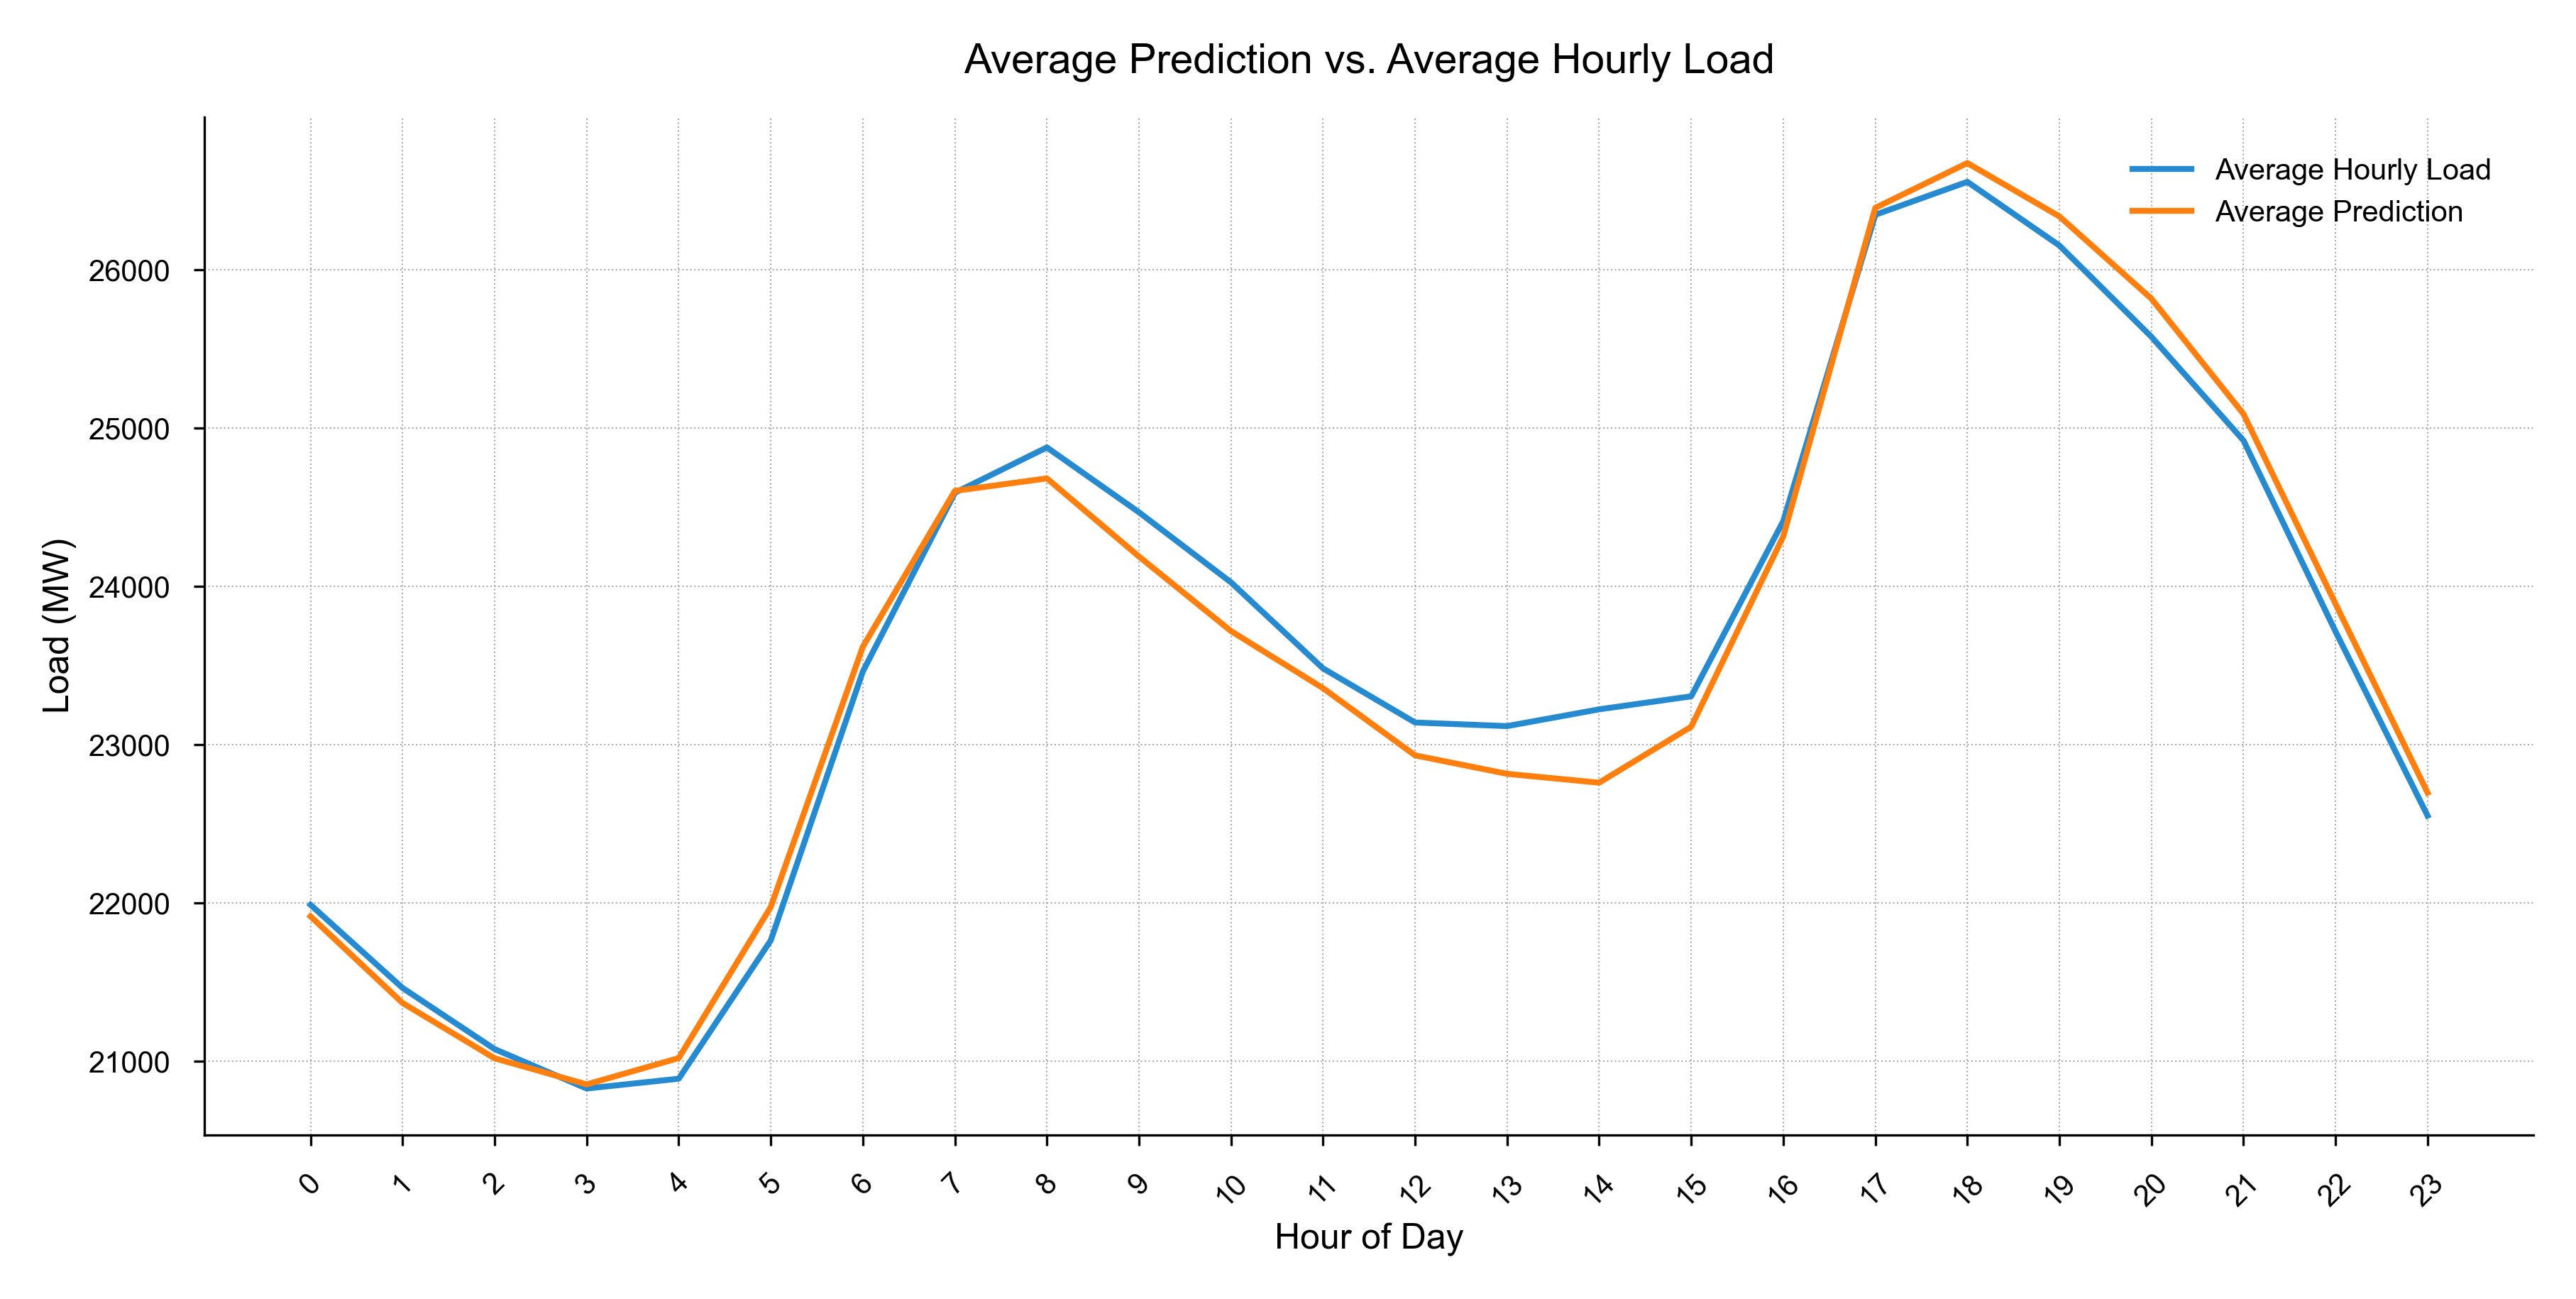

In [20]:
# plot average prediction
plt.figure(figsize=(12, 6))
plt.plot(avg_true_values, label="Average Hourly Load", linewidth=2)
plt.plot(avg_predictions, label="Average Prediction", linewidth=2)
plt.title("Average Prediction vs. Average Hourly Load")
plt.xlabel("Hour of Day")
plt.ylabel("Load (MW)")
plt.xticks(range(24), rotation=45)
plt.legend()
plt.show()

In [21]:
avg_error_by_hour = np.mean(np.array(results["predictions"]) - np.array(results["true_values"]), axis=0)
# avg_var_by_hour = np.var(np.array(true_values), axis=0)

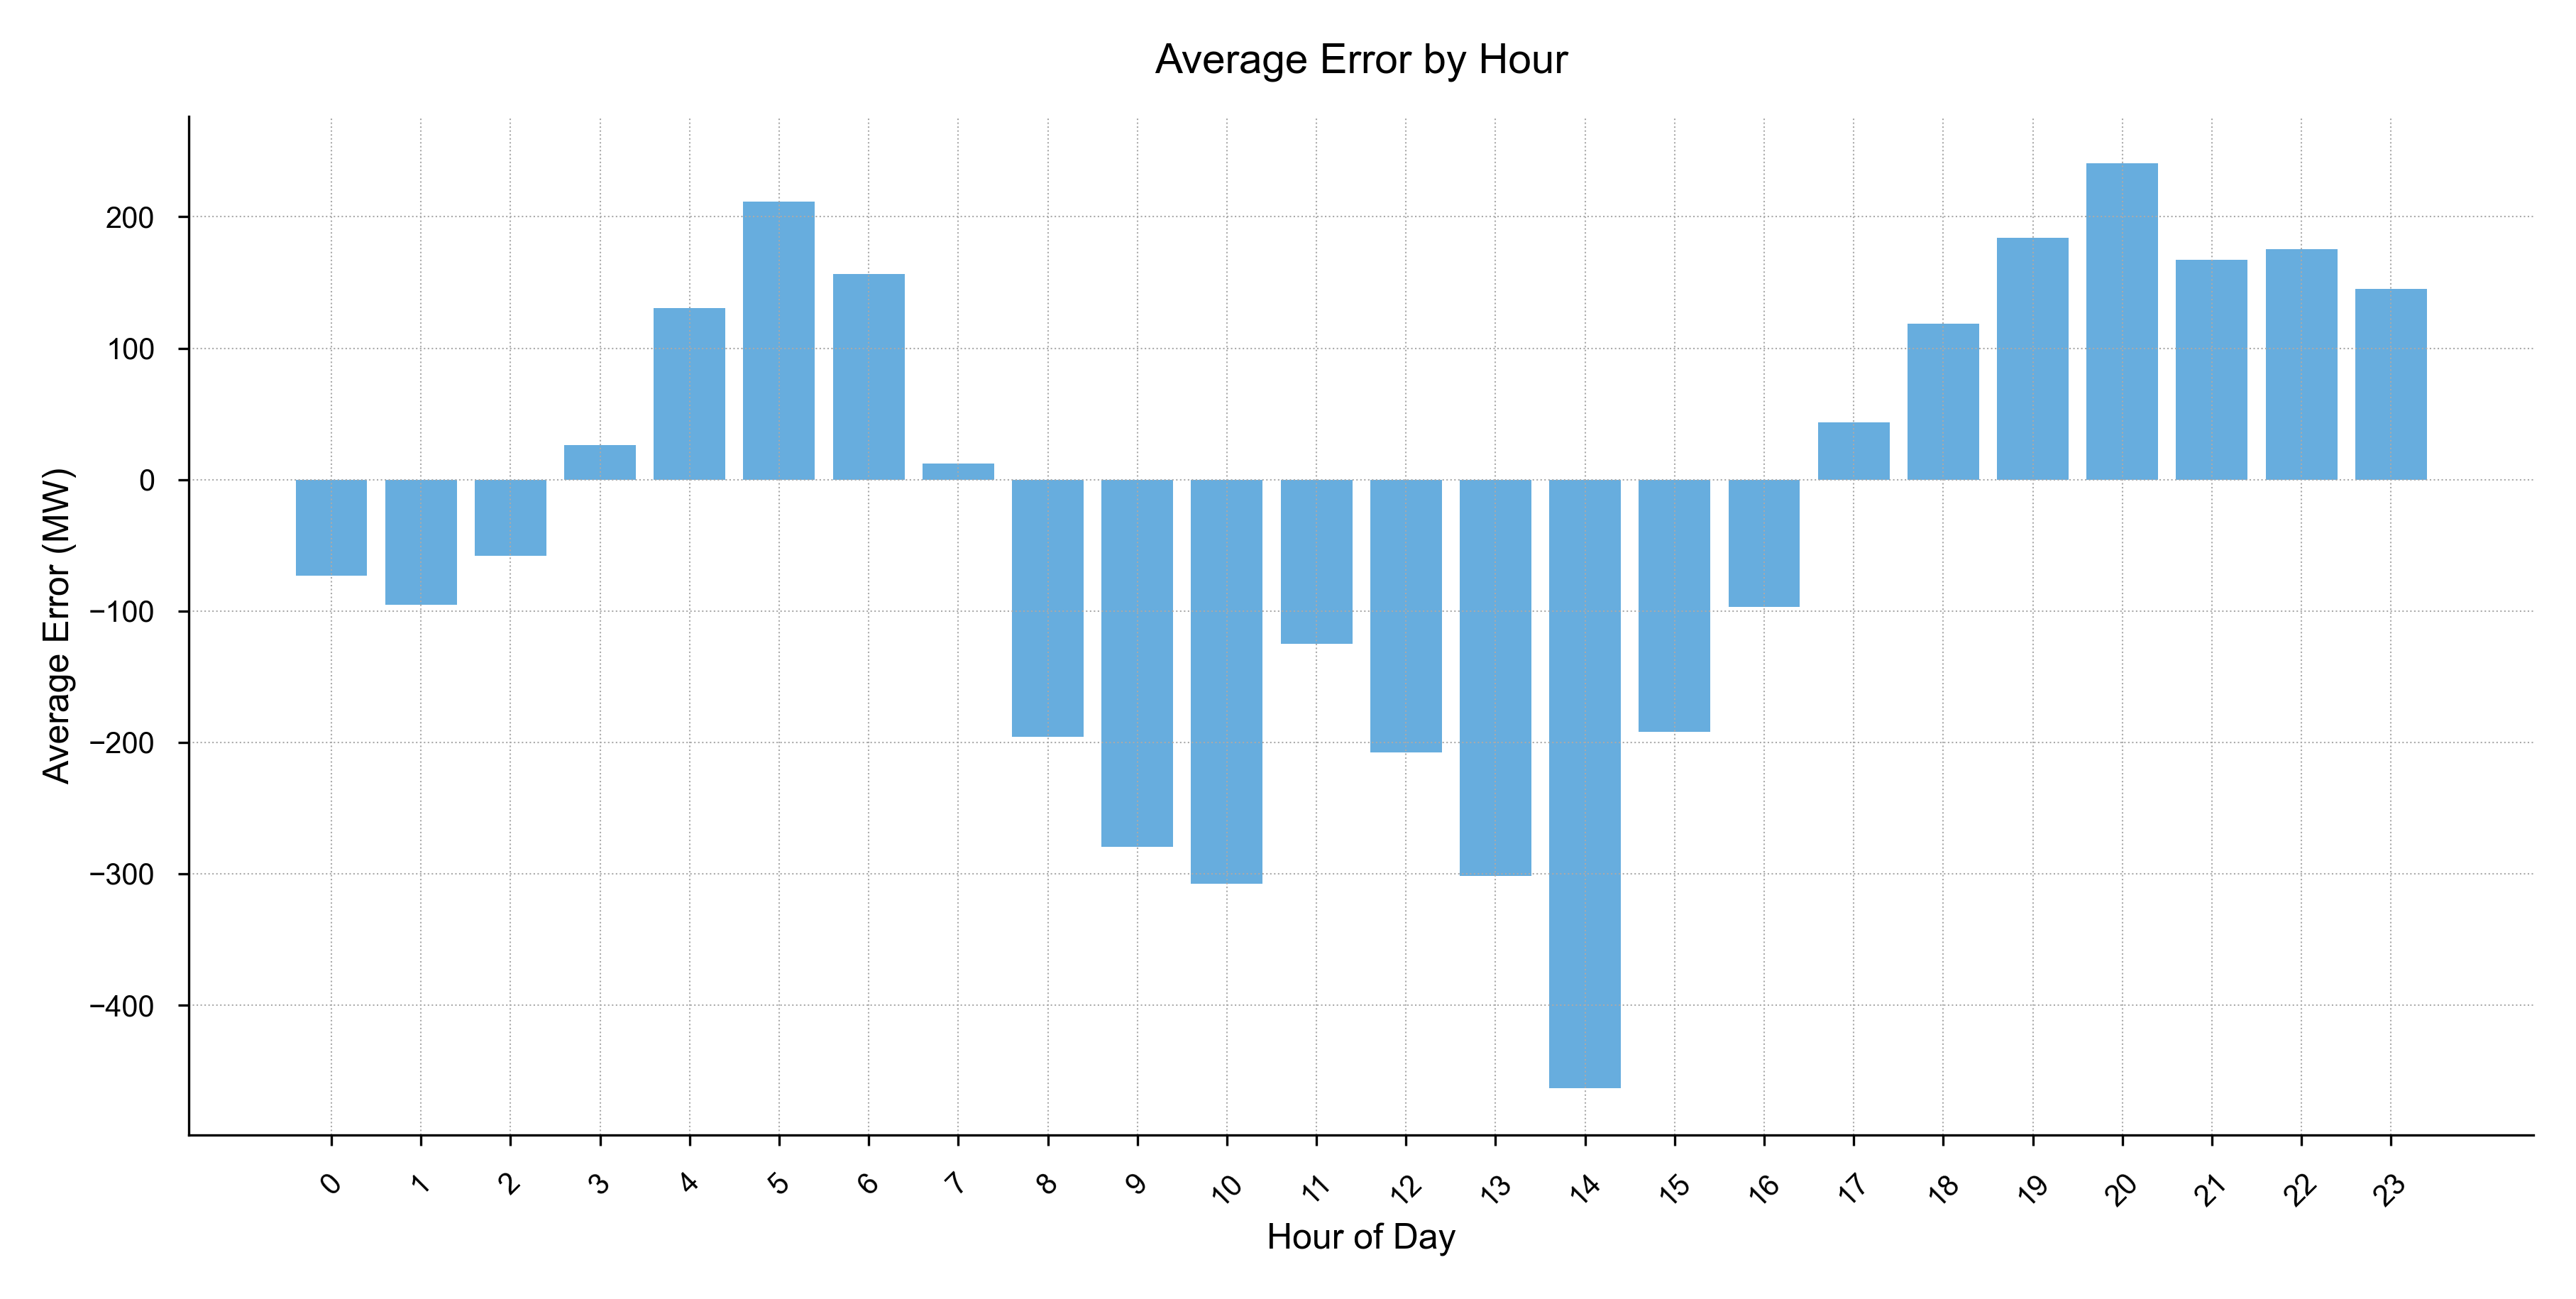

In [22]:
# plot bar chart of average error by hour
plt.figure(figsize=(12, 6))

# conditionally color bars based on error
# colors = ['green' if x < 0 else 'red' for x in avg_error_by_hour]
# plt.bar(range(24), avg_error_by_hour, color=colors, alpha=0.7)

plt.bar(range(24), avg_error_by_hour, alpha=0.7, zorder=1)
# plt.bar(range(24), avg_var_by_hour, alpha=0.5)
plt.title("Average Error by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Error (MW)")
plt.xticks(range(24), rotation=45)
# plt.yticks([])
plt.show()